# Bike Rental

**Daily bike rental ridership prediction using an artificial neural network in Keras**

**Supervised Learning. Regression**


Based on the [first neural network project](https://github.com/udacity/deep-learning/tree/master/first-neural-network) from the [Deep Learning Nanodegree Foundation of Udacity](https://www.udacity.com/course/deep-learning-nanodegree-foundation--nd101)

Click [Here](https://github.com/angelmtenor/deep-learning/blob/master/first-neural-network/dlnd-your-first-neural-network.ipynb) to check my original solution in Numpy

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import helper
#%reload_ext helper
import keras

helper.info_gpu()
sns.set_palette("Reds")
helper.reproducible(seed=0) # Setup reproducible results from run to run using Keras

Using TensorFlow backend.


/device:GPU:0
Keras		v2.1.3
TensorFlow	v1.4.1


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/Bike-Sharing-Dataset/hour.csv'
target = ['cnt', 'casual', 'registered']

df = pd.read_csv(data_path)
print("rows: {} \ncolumns: {} \ntarget: {}".format(*df.shape, target))

rows: 17379 
columns: 17 
target: ['cnt', 'casual', 'registered']


### Show data

In [3]:
df.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Numerical Data

In [4]:
df.describe(percentiles=[0.5])

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


#### Missing values

In [5]:
helper.missing(df);

No missing values found


### Transform features

#### Add new features

In [6]:
ind = pd.to_datetime(df['dteday'])
df['day'] = pd.DatetimeIndex(ind).day

#### Remove irrelevant features

In [7]:
irrelevant_features = ['atemp', 'day', 'instant']
df.drop(irrelevant_features, axis='columns', inplace=True)

### Classify variables

In [8]:
# numerical = list(df.select_dtypes(include=[np.number]))
df = helper.classify_data(
    df, target, numerical=['temp', 'hum', 'windspeed', 'cnt', 'casual', 'registered'])

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

numerical features:   3
categorical features: 9
target 'cnt': float32
target 'casual': float32
target 'registered': float32


,temp,hum,windspeed,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,cnt,casual,registered
Type,float32,float32,float32,category,category,category,category,category,category,category,category,category,float32,float32,float32


### Visualize the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. We also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. Below is a plot showing the hourly rentals over the first 10 days in the data set. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week.

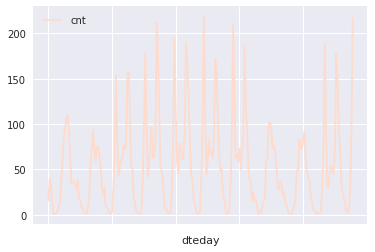

In [9]:
df[:24 * 10].plot(x='dteday', y='cnt');

#### Categorical features

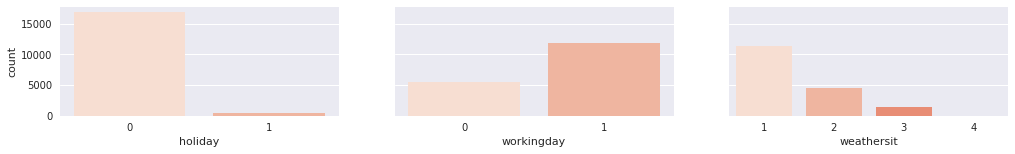

In [10]:
helper.show_categorical(df[['holiday', 'workingday', 'weathersit']], sharey=True)

#### Target vs Categorical features

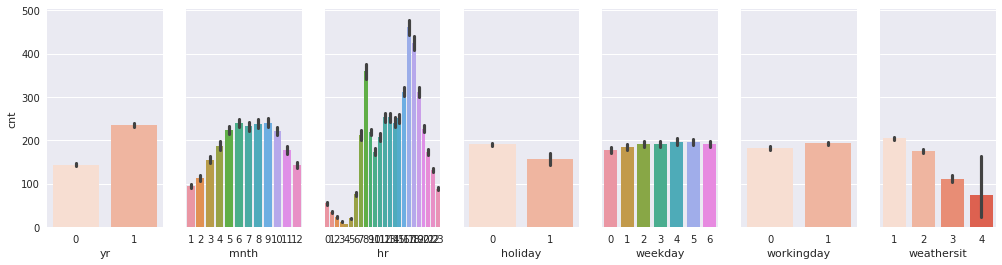

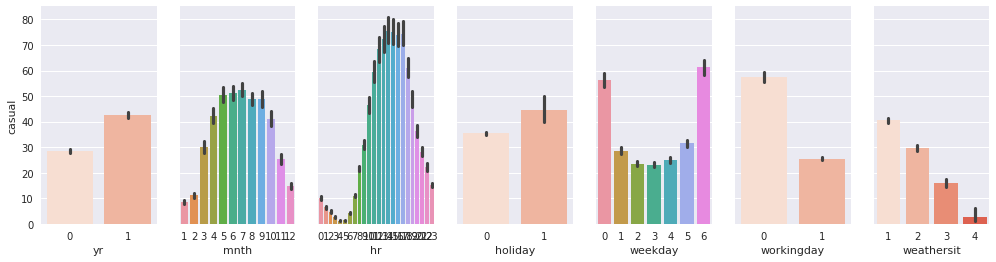

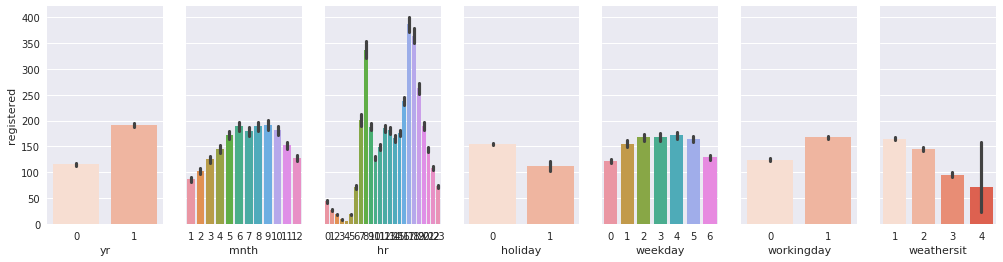

In [11]:
helper.show_target_vs_categorical(df.drop(['dteday', 'season'], axis='columns'), target)

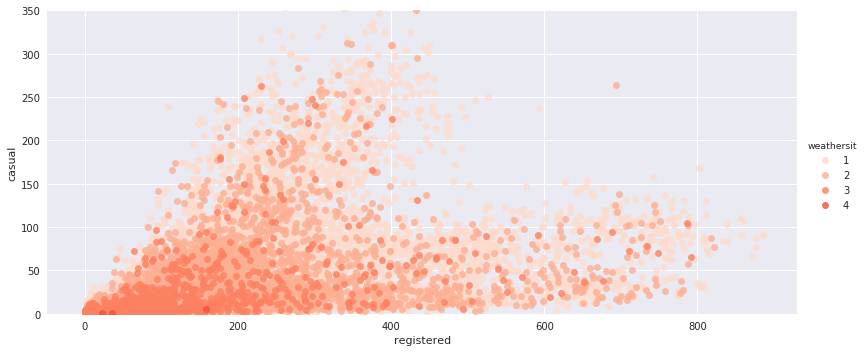

In [12]:
g = sns.PairGrid(df, y_vars='casual', x_vars='registered', size=5, aspect=9/4, 
                 hue = 'weathersit')
g.map(sns.regplot, fit_reg=False).add_legend()
g.axes[0, 0].set_ylim(0,350);

This plot shows the differences between the number of registered and casual riders for the different weather situations. Most of the riders are registered with very bad weather (`weathersit=4`).

#### Numerical features

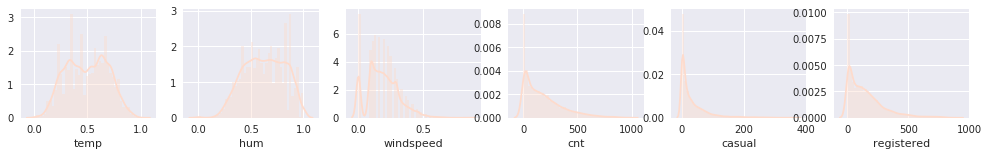

In [13]:
helper.show_numerical(df, kde=True)

#### Target vs numerical features

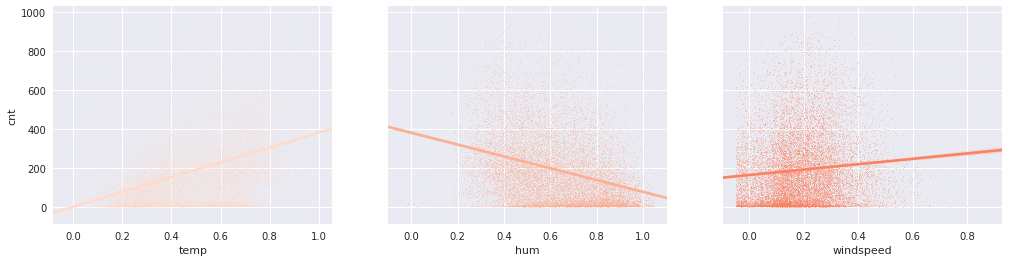

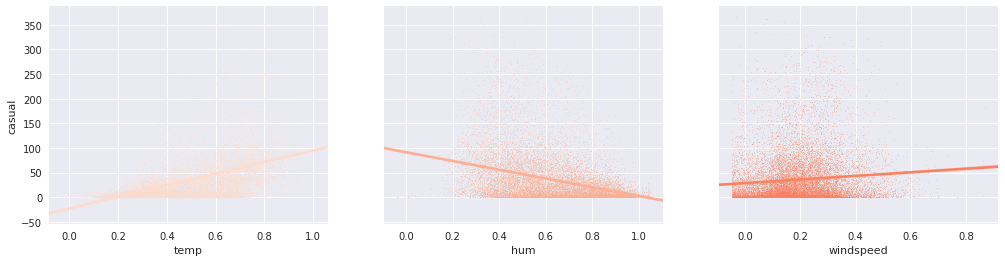

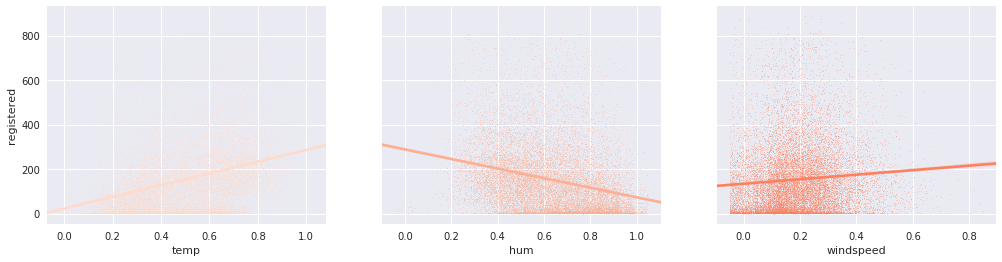

In [14]:
helper.show_target_vs_numerical(df, target, jitter=0.05)

#### Correlation between numerical features and target

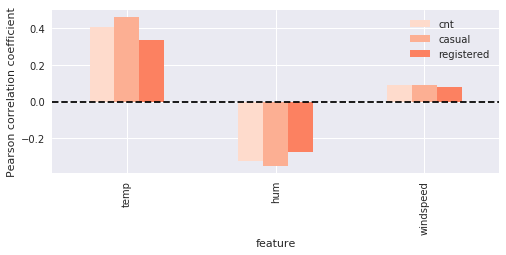

In [15]:
helper.show_correlation(df, target)

## 2. Neural Network model

### Select the features

In [16]:
drop_features = ['dteday'] # features to drop from the model

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(drop_features, axis='columns', inplace=True)
data.head(3)

,temp,hum,windspeed,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,cnt,casual,registered
0,0.24,0.81,0.0,1,0,1,0,0,6,0,1,16.0,3.0,13.0
1,0.22,0.80,0.0,1,0,1,1,0,6,0,1,40.0,8.0,32.0
2,0.22,0.80,0.0,1,0,1,2,0,6,0,1,32.0,5.0,27.0


### Scale numerical variables

Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [17]:
data, scale_param = helper.scale(data)

### Create dummy features

In [18]:
data, dict_dummies = helper.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target] # sorted neural network inputs

data.head(3)

,temp,hum,windspeed,cnt,casual,registered,season_1,season_2,season_3,season_4,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,-1.334609,0.947345,-1.553844,-0.956312,-0.662736,-0.930162,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,-1.438475,0.895513,-1.553844,-0.823998,-0.561327,-0.804632,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2,-1.438475,0.895513,-1.553844,-0.868103,-0.622172,-0.837666,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0


### Split the data into training, validation, and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [19]:
# Save the last 21 days as a test set
test = data[-21 * 24:]
train = data[:-21 * 24]

# Hold out the last 60 days of the remaining data as a validation set
val = train[-60 * 24:]
train = train[:-60 * 24]

# Separate the data into features(x) and targets(y)
x_train, y_train = train.drop(target, axis=1).values, train[target].values
x_val, y_val = val.drop(target, axis=1).values, val[target].values
x_test, y_test = test.drop(target, axis=1).values, test[target].values

print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(x_val.shape, y_val.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(15435, 60) 	 Y:(15435, 3)
val size 	 X:(1440, 60) 	 Y:(1440, 3)
test size  	 X:(504, 60) 	 Y:(504, 3) 


### Build the Neural Network
  

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size

    model = Sequential()
    model.add(Dense(input_nodes, activation='relu', input_dim=input_size))
    model.add(Dropout(.2))
    model.add(Dense(n_nodes // 2, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(3))
    
    if summary:
        model.summary()

    model.compile(loss='mean_squared_error', optimizer='rmsprop')

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

### Train the Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 93        
Total params: 5,583
Trainable params: 5,583
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 2.6 s


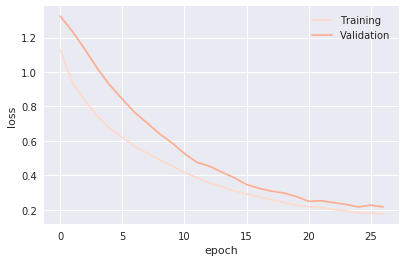


Training loss:  	0.1757
Validation loss: 	0.2164

Model saved at models/bike_rental.h5 



In [28]:
from time import time
model_path = os.path.join("models", "bike_rental.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network. 
    """

    if show:
        print('Training ....')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        validation_data=validation_data,
        epochs=100,
        batch_size=2048,
        verbose=0,
        callbacks=callbacks)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at {} \n".format(path))

    return history


model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, validation_data=[x_val, y_val], path=model_path)

In [29]:
from sklearn.metrics import r2_score

predicted_train_targets = model.predict(x_train)
predicted_val_targets = model.predict(x_val)

print('Training   R2-score: {:.3f}'.format(r2_score(y_train, predicted_train_targets)))
print('Validation R2-score: {:.3f}'.format(r2_score(y_val, predicted_val_targets)))

Training   R2-score: 0.890
Validation R2-score: 0.827


### Evaluate the model

In [30]:
# model = keras.models.load_model(model_path)
# print("Model loaded:", model_path)

print("Test loss:\t{:.4f}".format(model.evaluate(x_test, y_test, verbose=0)))

pred = model.predict(x_test)
print('Test R2-score:  {:.3f}'.format(r2_score(np.array(y_test), pred)))

Test loss:	0.1053
Test R2-score:  0.740


### Make predictions

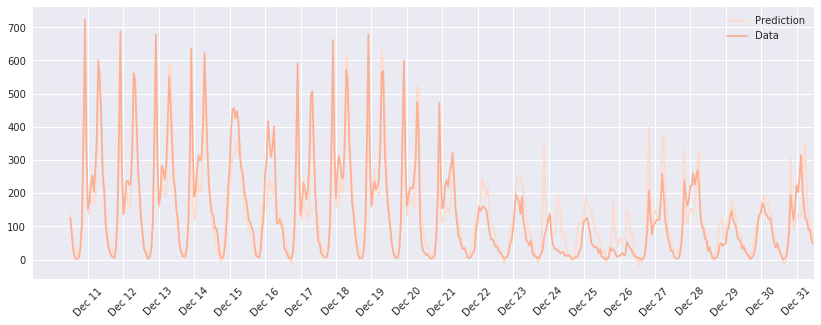

In [31]:
fig, ax = plt.subplots(figsize=(14, 5))

mean, std = scale_param['cnt']
predictions = pred * std + mean
ax.plot(predictions[:, 0], label='Prediction')
ax.plot((test['cnt'] * std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

The model seems quite accurate considering that only two years of data were available.

It fails on the last 10 days of December where we expected more bike riders.

The model was not trained to predict this fall. The training set included data from December 22 to December 31 from one year only (2011), which is not enough. An exploratory analysis and some tests with different models led me to the following results and conclusions:
    
- Adding more features from the dataset has a negligible impact on the accuracy of the model, only increasing the size of the neural network. 

- Removing or replacing the current features makes the model worse.

- The training period December 22 to December 31 in 2011 had more registered riders (mean = 73.6) than the test period in 2012 (mean = 58.3). A ridership drop on Christmas 2012 can be predicted from the weather (worse than 2011), but not the large decline registered. Adding new features could help solve this issue, such as *active registrations* or *Christmas*.